# **Detecció de línies de carrils amb OpenCV** 

Aquest notebook conté el codi per detectar les línies de carrils de qualsevol imatge o vídeo de forma precisa utilitzant Python i la llibreria OpenCV ("Open Source Computer Vision"), entre altres.


# Definim el PipeLine d'execució del programa

1. Escala de grissos
2. Suavitzat gaussià
3. Canny Edge Detection
4. Enmascarament de la regió
5. Transformada de Hough
6. Dibuixar línies

**By: Maria Barnils Sagués & Miquel Monge Dalmau**

-----------------------------------------------------------------------------------------------------

In [208]:
# Importem totes les biblioteques que farem servir
import math
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

**Funció per passar a escala de grissos una imatge**

In [209]:
def im_to_gray(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

**Apliquem la transformació Cany**

In [308]:
def canny(im, low_threshold, high_threshold):
    kernel = np.ones((11,11),np.uint8)
    canny = cv2.Canny(im, low_threshold, high_threshold)
    dilatacion = cv2.dilate(canny,kernel,iterations = 1)
    plt.imshow(dilatacion)
    return dilatacion

**Apliquem el GasussianBlur**

In [211]:
def gaussian_blur(im, kernel_size):
    return cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)

**ROI: Region of Interest**

Apliquem una màscara. Només conservem la regió de la imatge definida pel polígon format a partir de vèrtexs. La resta de la imatge es posa en negre. Vèrtex es una matriu de punts enters.

In [212]:
def region_of_interest(im, vertices):
    
    # Inicialitzem una màscara
    mask = np.zeros_like(im)   
    
    # Depenent de la imatge d'entrada definim 3 o 1 canal per 'omplir' la màscara
    if len(im.shape) > 2:
        num_canals = im.shape[2]  
        mask_color = (255,) * num_canals
    else:
        mask_color = 255

    # Omplim els píxels dins del polígon definit per "vèrtexs" amb el color
    cv2.fillPoly(mask, vertices, mask_color)
    
    # Comparem els píxels de 'im' amb la mascara i retornem els que no siguin 0. 
    masked_image = cv2.bitwise_and(im, mask)
    
    return masked_image

**Funció per dibuixar les líneas detectades**

In [213]:
def draw_lines(im, lines, color = [255, 0, 0], thickness = 10):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(im, (x1, y1), (x2, y2), color, thickness)

**Funció per calcular el pendent de les rectes**

Utilitzant l'equació de la recta (y = mx + c).

In [24]:
def calc_pendent_lines(im, lines):
    
    img = im.copy()
    vertex_polygon = []
    ordre = [0,1,3,2]

    left_lines = [] 
    right_lines = [] 
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2:
                pass # Línies verticals
            else:
                # per caclular equació recta
                m = (y2 - y1) / (x2 - x1) # pendent de la recta
                c = y1 - m * x1 

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

 
    left_line = np.mean(left_lines, axis = 0)
    right_line = np.mean(right_lines, axis = 0)



    for pendent, intercept in [left_line, right_line]:
        if pendent==0:
            pendent = 0.339947
        if intercept ==0:
            intercept = 132.690
        # Obtenim una alçada completa de la imatge en y1
        rows, cols = im.shape[:2]
        y1 = int(rows)

        # Agafant y2 fins al 60% de l'alçada real o el 60% de y1
        y2 = int(rows*0.6) 

        # Sabem que l'equació de línia és y = mx + c, de manera que podem escriure-la x = (y-c) / m
        x1 = int((y1-intercept)/pendent)
        x2 = int((y2-intercept)/pendent)
        vertex_polygon.append((x1, y1))
        vertex_polygon.append((x2, y2))
        # Dibuixem els carrils
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))

    # Afegim vertex al poligon de forma ordenada [0,1,2,3]
    vertex_polygon = [vertex_polygon[i] for i in ordre]

    # Omplim de color verd la zona delimitada pels vertex del poligon. 
    cv2.fillPoly(im, pts = np.array([vertex_polygon], 'int32'), color = (0,255,0))

    return cv2.addWeighted(im, 0.7, im, 0.4, 0.0)
    

**Hough Transform**

Retorna una imatge amb les línies de traçat dibuixades.

In [19]:
def hough_lines(img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180):
    
    # Calculem la transformada de Hough amb un subconjunt de punts triats aleatoriament. 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength = min_line_len, maxLineGap = max_line_gap)
    
    # Inicilitzem el vector. 
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # Cridem a calc_pendent_lines per dibuixar les lineas en la imatge line_img
    line_img = calc_pendent_lines(line_img, lines)
    
    return line_img, lines

In [260]:
def weighted_img(img, initial_img, alpha = 0.1, betha = 1.,  gamma = 0.):
    """
    img = iamtge amb els carrils marcats en blanc
    initial_img iamtge abans de ser processada
    El resultat s'obté al fer les següents operacions  = initial_img * alpha + img * betha + gamma
    """
    lines_edges = cv2.addWeighted(initial_img, alpha, img, betha, gamma)
    
    return lines_edges

**Funció per agafar els vèrtex d'una imatge**

Retorna els vèrtex.

In [261]:
def get_vertices2(line):
    x1, y1, x2, y2 = line[0][0]
    xf1, yf1, xf2, yf2 = line[-1][0]
    a = line[0][0][0:2] 
    b = line[-1][0][-2:]
    return [[x1, y1], [x2, y2], [xf1, yf1], [xf2, yf2]]

In [262]:
def get_vertices3(vertex):
    vertex = np.array([vertex], dtype = np.int32)
    return vertex

-------------------------------------------------------------------------------------------------

# **Definim l'execució del programa (pipeline)** 

S'implementa el ordre d'execució que s'ha definit en l'inici del script.


In [30]:
def main(im):
    # Passem a escala de grissos
    gray_img = im_to_gray(im)
    
    # Suavitzat gaussià
    smoothed_img = gaussian_blur(gray_img, 5)
    
    # Canny Edge Detection
    canny_img = canny(smoothed_img, 185, 240)
    canny_img_houg = canny(smoothed_img, 185, 240)

    # Transformada de Hough
    houghed_lines, lines = hough_lines(canny_img_houg)

    # Enmascarament de la regió
    a = get_vertices2(lines)
    b = get_vertices3(a)
    masked_img = region_of_interest(canny_img, b)

    # Transformada de Hough
    houghed_lines, lines = hough_lines(masked_img)
    
    # Dibuixar línies
    output = weighted_img(houghed_lines, im, 0.8, 1.0, 0.0)


    return gray_img, smoothed_img, canny_img, masked_img, houghed_lines, output


**Executem el programa**

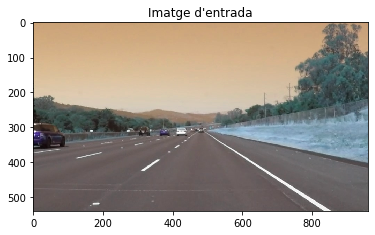

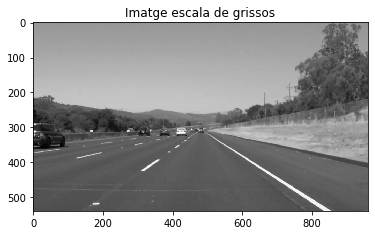

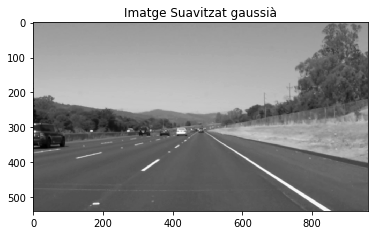

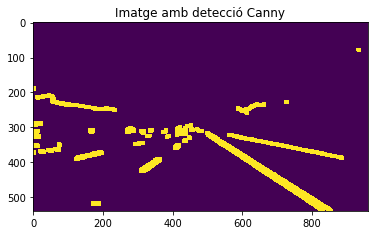

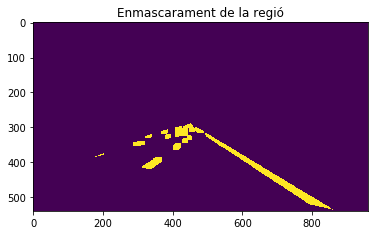

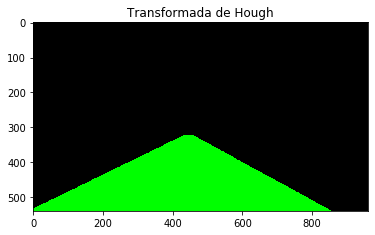

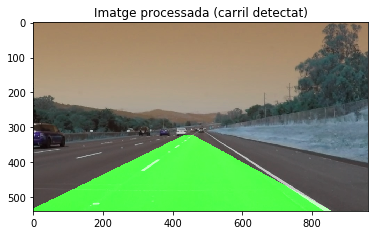

----------------------------------------------------------------------------------------------


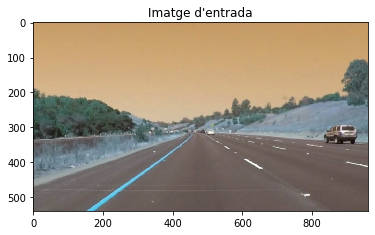

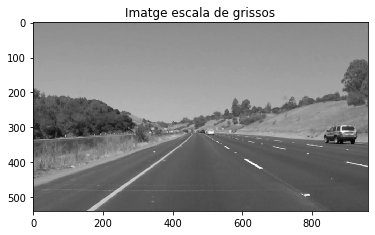

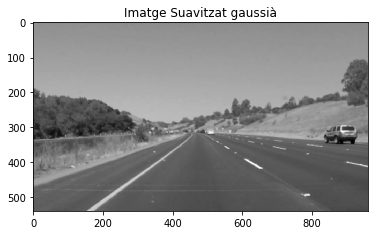

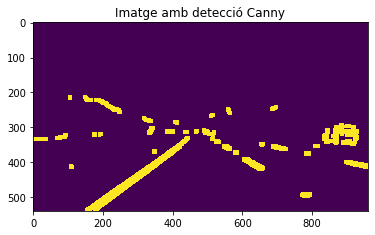

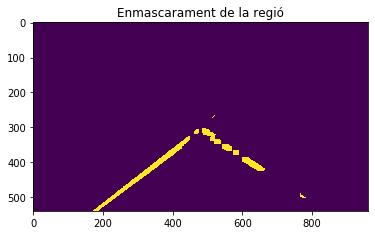

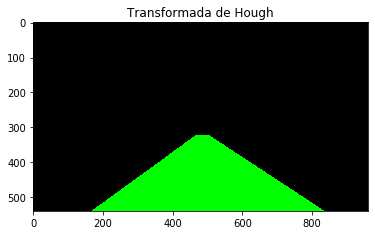

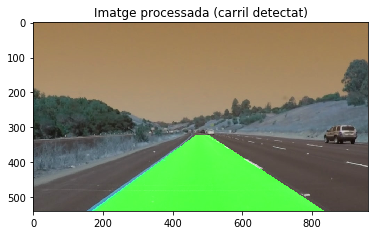

----------------------------------------------------------------------------------------------


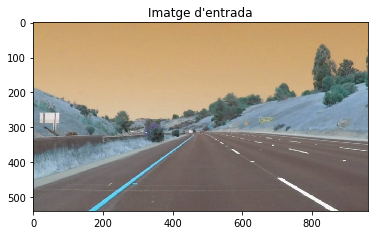

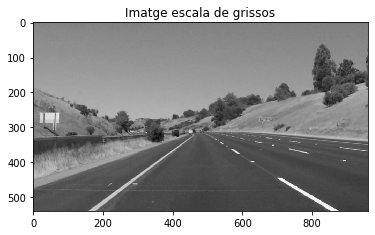

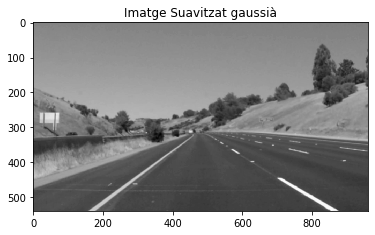

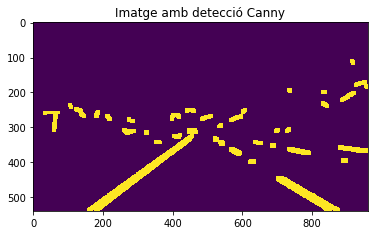

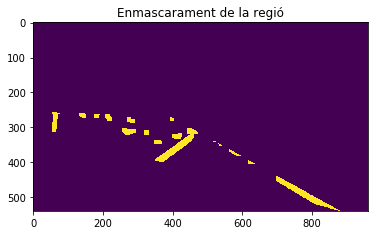

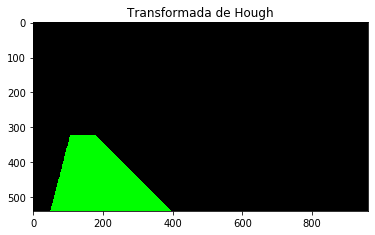

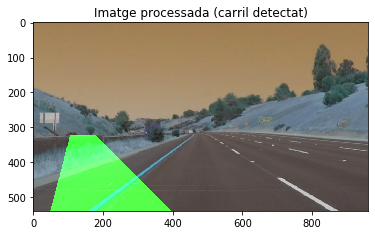

----------------------------------------------------------------------------------------------


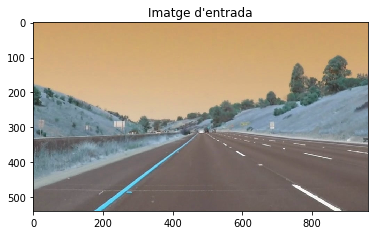

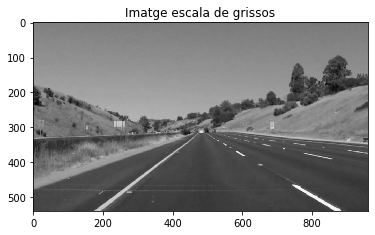

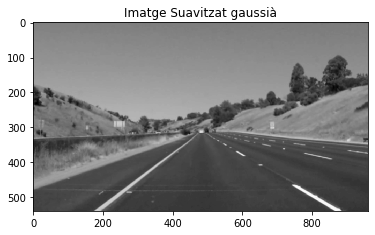

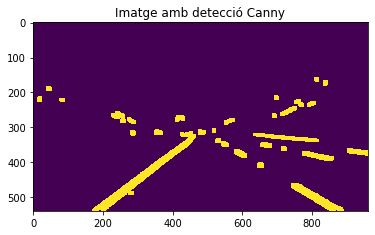

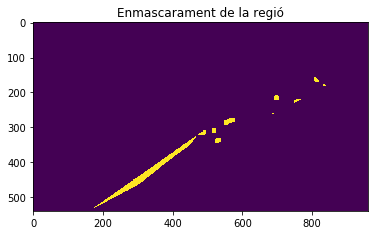

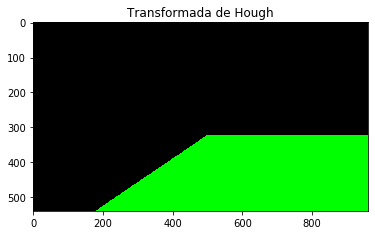

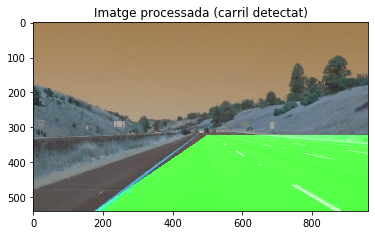

----------------------------------------------------------------------------------------------


In [35]:
path = r'C:\Users\Miquel Monge Dalmau\Desktop\Projecte PSIV\Code\test\img' # path amb les imatges
im_paths = list(os.listdir(path)) # llegim el path de les imatges

for im_path in im_paths:
    # Mostrem la imatge abans del processament
    im = cv2.imread(f'{path}/{im_path}')
    plt.imshow(im)
    plt.title("Imatge d'entrada")
    plt.show()

    # Fem el processament de la imatge
    gray_img, smoothed_img, canny_img, masked_img, houghed_lines, output = main(im)
    
    # Imatge en grissos
    plt.imshow(gray_img, cmap = 'gray')
    plt.title("Imatge escala de grissos")
    plt.show()

    # Imatge Suavitzat gaussià
    plt.imshow(smoothed_img, cmap = 'gray')
    plt.title("Imatge Suavitzat gaussià")
    plt.show()
    
    # Canny Edge Detection
    plt.imshow(canny_img)
    plt.title("Imatge amb detecció Canny")
    plt.show()
    
    # Enmascarament de la regió
    plt.imshow(masked_img)
    plt.title("Enmascarament de la regió")
    plt.show()
    
    # Transformada de Hough
    plt.imshow(houghed_lines)
    plt.title("Transformada de Hough")
    plt.show()
    
    # Dibuixar línies
    plt.imshow(output)
    plt.title("Imatge processada (carril detectat)")
    plt.show()
    
    # Guardem la imatge final
    cv2.imwrite(f'{im_path}', output)
    
    print("----------------------------------------------------------------------------------------------")